# Comparing Personalization: LOSO vs Within-Subjects

## Set up the Notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
if(importlib.util.find_spec("mFlow") is None):
    !git clone https://github.com/mlds-lab/mFlow.git
    !pip install ./mFlow
else:
    print("mFlow module found")

mFlow module found


## Import modules

In [3]:
from mFlow.Blocks.data_loader_extrasensory import extrasensory_data_loader
from mFlow.Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from mFlow.Blocks.imputer import Imputer
from mFlow.Blocks.normalizer import Normalizer
from mFlow.Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from mFlow.Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from mFlow.Workflow.workflow import workflow
import mFlow.Workflow.compute_graph

## Define the workflow

This workflow compares a within-subject experimental design to the leave-one-subject-out (LOSO) design. In the first case, one model is trained per subject using only that subject's data. In the second case, for each subject, a model is trained using data from all other subjects and then applied to the target subject. The within-subject design thus corresponds to a personalized model fit to an individual subject, while the LOSO design corresponds to using a model fit to other subjects.  We use the ExtraSensory data set sleeping prediction task using a subset of the first 50,000 instances. The model used is logistic regression with a default regularization hyper-parameters. 

The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, and a missing label filter that removes instances without labels. Next, the workflow performs mean imputation followed by feature normalization. Finally,  each of the two experimental protocols are applied. Results are displayed per-subject.

In this particular case, we see that the accuracy measured by the within-subject protocol is slightly better than that of the LOSO design, but the difference does not look significant. Further, it is important to remember that the LOSO and within-subjects test sets are not the same due to the fact that some data for each subject are used for training in the within-subject design, so more work is needed to conclusively state that personalization provides an advantage for this task.


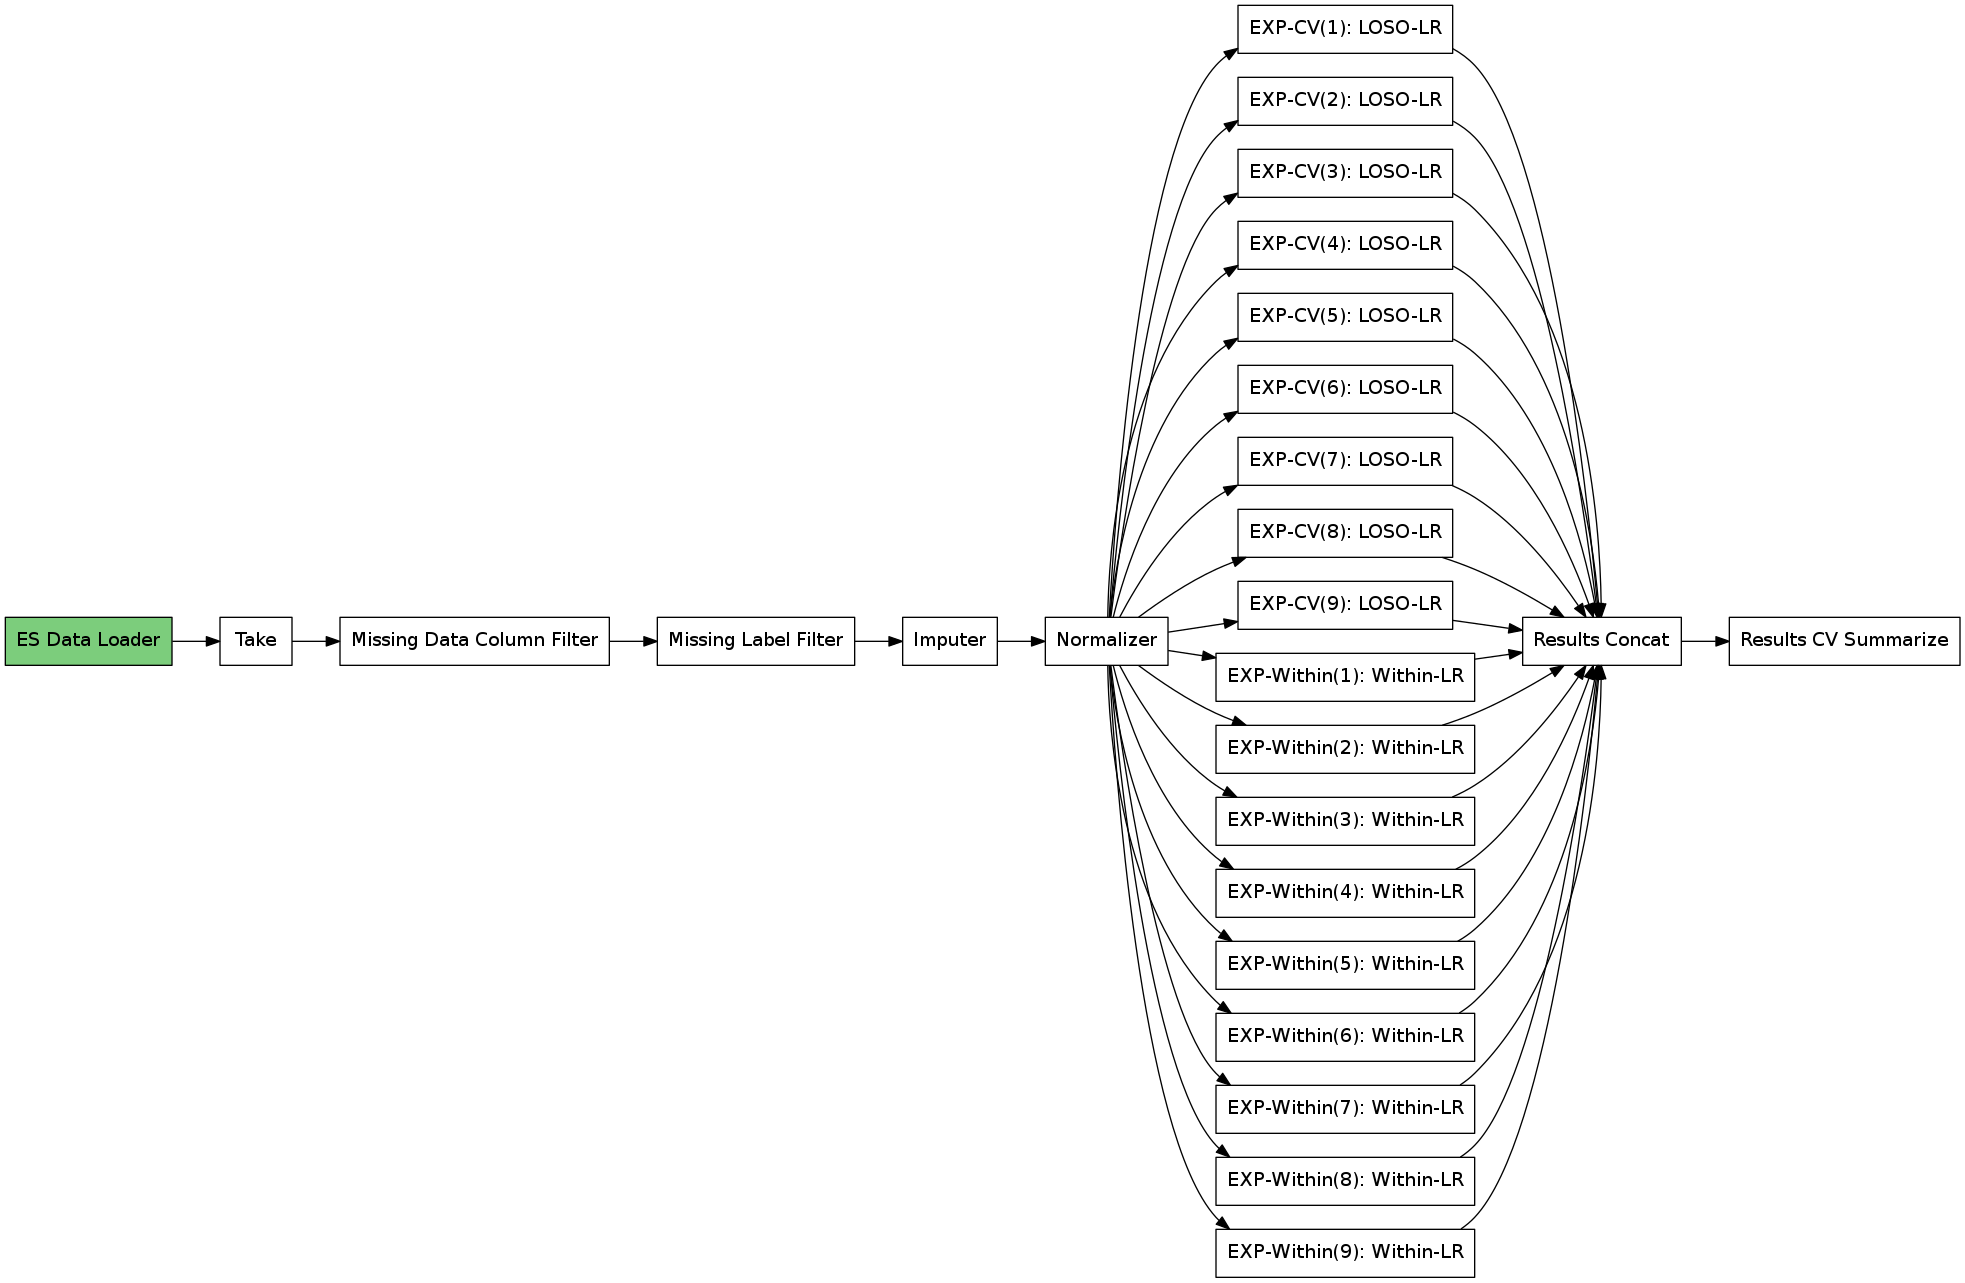

  Loading Extrasensory pkl file...


In [ ]:
metrics   = [accuracy_score, f1_score, precision_score, recall_score]
df_raw    = extrasensory_data_loader(label="SLEEPING");
df_sub    = Take(df_raw, 50000)
df_cf     = MisingDataColumnFilter(df_sub);
df_lf     = MisingLabelFilter(df_cf);
df_imp    = Imputer(df_lf)
df_norm   = Normalizer(df_imp);
report    = DataYieldReport(df_norm, names=["Norm"])

flow      = workflow({"yield":report});
flow.draw(); plt.show();
output    = flow.run();
num       = output['yield']['report']["#Individuals with Data"]["Norm"]
display(output['yield']['report'])

estimators1 = {"Within-LR": LogisticRegression(solver="lbfgs",max_iter=100)}
res_within = ExpWithin(df_norm, estimators1, metrics=metrics, n_folds=num);

estimators2 = {"LOSO-LR": LogisticRegression(solver="lbfgs",max_iter=100)}
res_loso   = ExpCV(df_norm, estimators2, metrics=metrics, n_folds=num);

res_cat   = ResultsConcat(res_loso, res_within)
summary   = ResultsCVSummarize(res_cat)
flow=workflow({"results":summary})
 
output=flow.run(backend="sequential", monitor=True,from_scratch=True);


In [ ]:
output["results"]["report"]